## Simulation based inference: how to estimate G posterior distribution

The last step of the VAB workflow employs Simulation Based Inference (SBI) for estimation of the full posterior values of the parameter $G$. Here, a deep neural estimator is trained to provide a relationship between the parameters of a model (black box simulator) and selected descriptive statistics of the observed data. 

The procedure is split into following steps:

1. Simulations using parameters drawn from the prior distributions
2. Training the deep neural estimator (sequential neural posterior estimation, SNPE)
3. Computing the posterior density with respect to the empirical observables.

The SBI algorithm might be very computationally demanding due to the first step. In order to provide all the necessary details to replicate SBI, we make the assumptions that all necessary simulations have been computed and stored in the `$MYPATH/aging_virtual_brain/data/interim`. 

The second step is less computationally demanding, but it could benefit from a parallel computing solutions. To show how to obtain G distribution without using any extra computational resources, we are going to report the SBI solutions of the VAB pipeline in two notebooks. In the current one, we show how to run the deep neural estimator to obtain $G$ for a subcohort.

The notebook `$MYPATH/aging_virtual_brain/notebooks/vab_github_SBI_1000BD.ipynb` shows the output results of the second step for the entire 1000BRAINS cohort. 

Before proceeding in any further explanation of the SBI employed in the VAB pipeline, we remind that the intermediate simulations are also personal data. Therefore, we invite the user to read the following code blocks.

## Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external` and the simulated dataset is located in the folder `$MYPATH/aging_virtual_brain/data/interim`. First, verify that the datasets are present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

## Import packages

Import the most useful packages for this notebook

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
from sklearn import linear_model

Upload TVB packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import utils
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from src import data,analysis,simulation
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
from multiprocessing import Pool
from functools import partial
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
#import ipywidgets as widgets
# Pay attention that it crashes with any other interactive package
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
LOG = get_logger('demo')
import scipy.stats
from scipy.stats import zscore
#import sklearn
#from sklearn.decomposition import FastICA
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


Import the SBI packages

In [4]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi,simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

import scipy

from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

Define your target/results folder

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on numba: v{}'.format(numba.__version__))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))
print('Running on numpba: v{}'.format(numba.__version__))

Running on numpy: v1.20.2
Running on numba: v0.53.1
Running on torch: v1.8.1
Running on sbi: v0.16.0
Running on numpba: v0.53.1


#### Notebooks parameters

In [6]:
magic_number = 124538.470647693 #SC COHORT MAX FOR JULICH DATASET
BOLD_TR      = 2200
dt           = 0.05
eta          = -4.6
J            = 14.5
Delta        = 0.7
seed         = 42

A_TAU      = [0.0]
B_TAU      = [0.0]

ALPHA1     = A_TAU[0]
ALPHA2     = A_TAU[0]

transient      = int(5e3/500)
transient_tavg = int(5e3)

In [7]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul         = data.Julich() 
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs        = jul.list_subjects()
# SUBJ_TARG    = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
# print(subj_ID[SUBJ_TARG])
# print(subj_age[SUBJ_TARG])
# _,weights     = jul.load_subject_sc_100(mysubj)
# NHALF         = int(weights.shape[0]/2)

## Simulation-based inference

The global modulation parameter G of the brain network model can be also estimated by SBI tailored to Bayes rule in order to retrieve the model  parameter space compatible with the empirical data [Gonçalves et al., 2020](https://doi.org/10.7554/eLife.56261). Statistical inference consists of the automatic identification of possible parameters  via the likelihood function $p(X|\theta)$, which quantifies the probability that a given set $\theta$ generates the vector of raw data or low-dimensional data features $X$. The Bayesian estimation consists in $p(\theta|X) = p(X|\theta) p(\theta)$, where $p(\theta|X)$ is the posterior that quantifies the probabilistic consistency between the selected parameter space and fitted empirical data.

In the specific case of the VAB pipeline, we wanted to estimate the posterior distribution of $G$. Hence, 

$$p(G_{SBI}|X) = p(X|G_{SBI}) p(G_{SBI})$$

where $p(X|G_{SBI})$ is the likelihood function, which is obtained via SNPE with a flexible neural density estimation trained on low-dimensional data features. In short, SNPE traines a deep neural network on a certain budget of simulations (2000 in the VAB case) on set of low dimensional features ($X$).

The set of chosen low dimensional features are the homotopic FC ($<Homotopic_{FC}>$),FCD variance difference ($\sigma^2_{diff}$) and the standard deviation of interhemispheric FC stream.

$p(G_{SBI})$ is set as a uniform distribution of $G$ values (truncated between 1.5 and 3.2) containing as many samples as the chosen budge of simulation. See the following codeblock to generate a uniform distribution of 2000 Gs.

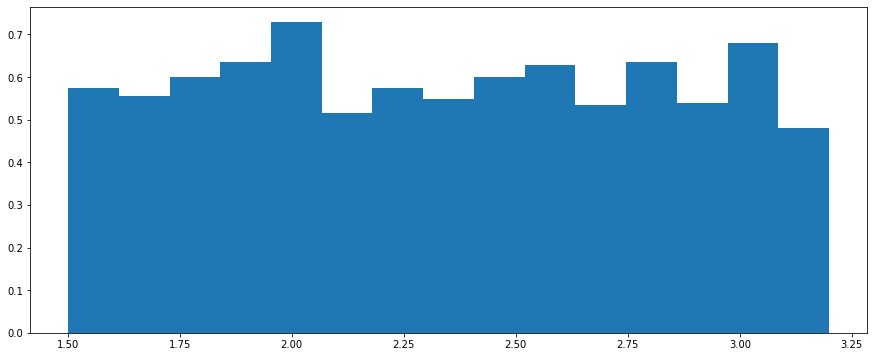

In [14]:
G_prior = np.random.uniform(1.5,3.2,2000)
count, bins, ignored = plt.hist(G_prior, 15, density=True)
plt.show()

Thanks to the uniform distribution, the final posterior is given by $p(G_{SBI}|X_{empirical}) = p(X_{simulated}|G_{SBI})$, which implies that the final estimation of the posterior is computed by the likelihood network via a feedfowrad feeding of the **empirical** summary statistics.

To estimate a posterior distribution for each individual, this procedure has to be repeated for each single subject, which require 2000 simulations, computation of the summary statistics for both the simulated and empirical data and the training of the deep neural network.  

Consequently, we decided to split the 2000 simulations task on HPC facilites, while this notebook will show how to train a deep neural network, feed it with the empirical summary statistics and obtain the posterior distribution.

In [8]:
Res_dir     = jul.data_root
path_root   = os.path.dirname(os.path.dirname(os.getcwd()))
cwd = os.getcwd()

Example list of subjects for the SBI estimation

In [ ]:
P_LIST = ['sub-0507',
 'sub-1247',
 'sub-0216',
...
 'sub-0271',
 'sub-0836',
 'sub-0529',
...
 'sub-0346',
 'sub-0358',
 'sub-0373',
 'sub-0375',
 'sub-0390',
 'sub-0395']

Once the prior G distribution is set, we can save it as a list and apply to all subjects. SBI has no clear advantage from this procedure, but having the same sampling for each subject allow parallel computation for the simulation budget.

In [13]:
G_LIST     = [2.9618384,
 3.1395926,
 2.0818776,
 1.8156225,
...
 2.4677862,
 3.0471092,
 1.8412488,
 2.6625926,
 1.7984856,
 2.5338452,
 2.223846,
 2.5988413,
 2.026169,
 2.8679142,
 2.6775879,
 2.0526757,
 2.3756662,
 2.8314022,
 2.2635491,
 3.1498051,
...
 2.5049841,
 2.4552386,
 3.1472196,
 2.3485284,
 2.067689,
 1.9535876,
 1.7769446]

In [14]:
print(len(G_LIST))


2000


In [ ]:
G_TAU      = G_LIST

In [17]:
def collect_gridsearch(G,noise,mysubj,alpha1,alpha2):
    
    separator       = ''
    
    str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
        
    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [18]:
def collect_usage(G,mysubj,alpha1,alpha2):
    
    separator       = ''
    
    str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_SBI_SECOND_COH_aug/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
        
    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [19]:
def collect_demo(G,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,mysubj,alpha1,alpha2)
    
    mysubj          = output_data['mysubj']
    myage           = output_data['myage']
    
    
    return mysubj,myage

In [20]:
def collect_bold(G,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,mysubj,alpha1,alpha2)
    
    bold            = output_data['Bold_data'][:,0,:,0]
    time_bold       = output_data['Bold_time']
    
    return bold,time_bold

In [21]:
def collect_FCD(G,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,mysubj,alpha1,alpha2)
    
    FCD_SUM_vect    = output_data['FCD_SUM_vect']
    FCD_MEAN_vect   = output_data['FCD_MEAN_vect']
    FCD_VAR_vect    = output_data['FCD_VAR_vect']
    FCD_OSC_vect    = output_data['FCD_OSC_vect']
    
    
    return FCD_SUM_vect,FCD_MEAN_vect,FCD_VAR_vect,FCD_OSC_vect

In [22]:
def collect_FCD_OV(G,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

In [23]:
def collect_FCD_INTER(G,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,mysubj,alpha1,alpha2)

    FCD_SUM_INTER_vect    = output_data['FCD_SUM_INTER_vect']
    FCD_MEAN_INTER_vect   = output_data['FCD_MEAN_INTER_vect']
    FCD_VAR_INTER_vect    = output_data['FCD_VAR_INTER_vect']
    FCD_OSC_INTER_vect    = output_data['FCD_OSC_INTER_vect']
    
    
    return FCD_SUM_INTER_vect,FCD_MEAN_INTER_vect,FCD_VAR_INTER_vect,FCD_OSC_INTER_vect

In [24]:
def collect_FCD_OV_INTER(G,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_INTER_vect    = output_data['FCD_SUM_OV_INTER_vect']
    FCD_MEAN_OV_INTER_vect   = output_data['FCD_MEAN_OV_INTER_vect']
    FCD_VAR_OV_INTER_vect    = output_data['FCD_VAR_OV_INTER_vect']
    FCD_OSC_OV_INTER_vect    = output_data['FCD_OSC_OV_INTER_vect']
    
    
    return FCD_SUM_OV_INTER_vect,FCD_MEAN_OV_INTER_vect,FCD_VAR_OV_INTER_vect,FCD_OSC_OV_INTER_vect

In [25]:
def collect_FCSC(G,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,mysubj,alpha1,alpha2)
    
    rsFC             = output_data['rsFC']
    FC_CORR          = output_data['FC_CORR']
    FS_CORR          = output_data['FS_CORR']
    
    return rsFC,FC_CORR,FS_CORR

In [26]:
def collect_FCD_OV_gs(G,noise,mysubj,alpha1,alpha2,flag_ds):
    
    output_data = collect_gridsearch(G,noise,mysubj,alpha1,alpha2,flag_ds)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

## 1. Collection of the summary statistics from simulated and empirical data

All the simulations were performed on HPC facilities and collected in the folder `$MYPATH/aging_virtual_brain/data/interim`. SBI needs a set of summary statistics to train the neural network and estimate the posterior distribution of $G$. The code blocks below collect all the summary statistics for the selected prior distribution and the associated parameters maps for the selected group of subject of this notebooks. They also collect all the summary statistics for the respective gridsearch/parameter sweep-based selection of G in order to compare the two methods. To speed up the process, the last code-block upload a separate intermediate file to upload all the selected summary statistics and perform the deep neural network training.  

The following codeblocks collect all the parameter-sweep based Gs, which will be compared with SBI estimate.

To speed up the process, we collect all Gs obtained with the regular sweep and the summary statistics obtained for the 2000 simulations in an intermediate file. An intermediate file also contains data that are labelled as personal. Therefore,

### ***Re-read carefully the data alert block***

In [35]:
str_save_feature     = separator.join(['interim/julich_100_VAB_SBI_summ_subset.npz'])

out_feature          = os.path.join(jul.data_root,str_save_feature)

summary_data         = np.load(out_feature)


P_LIST                    = summary_data["P_LIST"]
myage_list                = summary_data["myage_list"]
mysubj_list               = summary_data["mysubj_list"]

FCD_SUBJ_VAR_OV_GS        = summary_data["FCD_SUBJ_VAR_OV_GS"]

G_MAX                     = summary_data["G_MAX"]
N_MAX                     = summary_data["N_MAX"]

HOMO_FC                   = summary_data["HOMO_FC"]
FCD_STACK_STD_INTER_TENS  = summary_data["FCD_STACK_STD_INTER_TENS"]
FCD_SUBJ_DIFF_VAR_OV_TENS = summary_data["FCD_SUBJ_DIFF_VAR_OV_TENS"]

HOMO_FC_EMP               = summary_data["HOMO_FC_EMP"]
FCD_INTER_OSC_EMP         = summary_data["FCD_INTER_OSC_EMP"]
FCD_SUBJ_DIFF_VAR_OV_EMP  = summary_data["FCD_SUBJ_DIFF_VAR_OV_EMP"]

### 2. Prior over model parameters

SBI is based on PyTorch libraries to train the deep neural network. Therefore, all the variables have to be cast as tensor torch variables.

The prior is defined as a uniform tensor variable between 1.5 and 3.2

In [16]:
prior_min_G=1.5*np.ones(1)
prior_max_G=3.2*np.ones(1)

In [17]:
prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [38]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [39]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
prior

BoxUniform(Uniform(low: tensor([1.5000]), high: tensor([3.2000])), 1)

### 3. Inference

Although the inference function is defined with a wrapper for the simulation with the specific model of intereste in the SBI toolbox, the function below shows that you can potentially split the simulation step from the inference in case that it is needed. Since we want to parallelize the simulation on HPC facilities, we then need to provide the prior of our simulations (indicated by theta variable) and the summary statistics X.

The variable $X$ is indicated by the programming variable `sum_stats_vec` and is obtained by contatenating the $<homotopic_{FC}>$, $\sigma^2_{diff}(FCD)$ and the variability of the interhemispheric FC stream.

Once the uniform distribution of the parameter $\theta$ (i.e. $G$) and the summary matrix $X$ are set as torch tensor variables, the function `myinfer` will execute the training of the deep neural network. Once the neural network object `posterior` is trained, the  `posterior.sample` function returns the posterior distribution of $G$ once it is fed with the empirical summary statistics $X$.

The mean of the posterior distribution is considered as the final estimate of $G$.

In [40]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast
import sbi.inference
from sbi.inference.posteriors.base_posterior import NeuralPosterior

In [41]:
def myinfer(prior, theta, x):
    
    inference = SNPE(prior)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

    return posterior

In [48]:
num_samples   = 1000
G_POST_MATRIX = np.zeros([num_samples,len(P_LIST)])
G_POST_MEAN   = np.zeros(len(P_LIST))

for subj_idx in range(len(P_LIST)):
    
    start_time = time.time()

    sum_stats_vec = np.concatenate((HOMO_FC[:,subj_idx].reshape(HOMO_FC[:,subj_idx].shape[0],1), 
                                FCD_STACK_STD_INTER_TENS[:,subj_idx].reshape(FCD_STACK_STD_INTER_TENS[:,subj_idx].shape[0],1), 
                                FCD_SUBJ_DIFF_VAR_OV_TENS[:,subj_idx].reshape(FCD_SUBJ_DIFF_VAR_OV_TENS[:,subj_idx].shape[0],1))
                               ,axis=1)
    
    sum_stats_vec.shape
    
    
    sum_stats_vec = np.array(sum_stats_vec,dtype='float32')
    G_THETA       = np.array(G_TAU)
    G_THETA       = G_THETA[np.sum(np.isnan(sum_stats_vec),axis=1)==0]

    sum_stats_vec = sum_stats_vec[np.sum(np.isnan(sum_stats_vec),axis=1)==0,:]
    sum_stats_vec = sum_stats_vec[np.sum(sum_stats_vec,axis=1)<np.inf,:]
    
    sum_stats_vec.shape

    
    x     = sum_stats_vec
    x     = torch.as_tensor(x)
    theta = np.array(G_THETA,dtype='float32')
    theta = theta.reshape(theta.shape[0],1)
    theta = torch.as_tensor(theta)
    posterior = myinfer(prior, theta, x)
    
    print ("-"*60)
    print("--- %s seconds ---" % (time.time() - start_time))
    
#     obs_summary_statistics = np.array([HOMO_FC_EMP[subj_idx],FCD_MEAN_OV_EMP[subj_idx],FCD_VAR_OV_EMP[subj_idx],FCD_INTER_OSC_EMP[subj_idx],FCD_SUBJ_DIFF_VAR_EMP[subj_idx]])
    
    obs_summary_statistics = np.array([HOMO_FC_EMP[subj_idx],FCD_INTER_OSC_EMP[subj_idx],FCD_SUBJ_DIFF_VAR_OV_EMP[subj_idx]])

    posterior_samples = posterior.sample((num_samples,), obs_summary_statistics, sample_with_mcmc=True,).numpy()
    
    G_posterior       = posterior_samples[:,0]
    G_mean            = np.mean(G_posterior)
    mysubj            = P_LIST[subj_idx]
    
    G_POST_MATRIX[:,subj_idx] = G_posterior
    G_POST_MEAN[subj_idx]     = G_mean
    
    str_save        = separator.join(['interim/julich_coh_github_sbi/julich_sbi_G','_pat',f"{mysubj}",'.npz'])

    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.savez(out_path,G_mean=G_mean,G_posterior=G_posterior)
    
    

    

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 85 epochs.
------------------------------------------------------------
--- 44.62375092506409 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 94 epochs.
------------------------------------------------------------
--- 43.08056902885437 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:31<00:00, 10.92it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.
------------------------------------------------------------
--- 31.904112815856934 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.70it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 86.37it/s]

Neural network successfully converged after 62 epochs.
------------------------------------------------------------
--- 27.608466863632202 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.66it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 112 epochs.
------------------------------------------------------------
--- 47.28039789199829 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 79 epochs.
------------------------------------------------------------
--- 33.61610007286072 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:31<00:00, 10.97it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 45 epochs.
------------------------------------------------------------
--- 19.749802112579346 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 118 epochs.
------------------------------------------------------------
--- 49.77685594558716 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 55 epochs.
------------------------------------------------------------
--- 24.079138040542603 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 82 epochs.
------------------------------------------------------------
--- 35.54489016532898 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.35it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 124 epochs.
------------------------------------------------------------
--- 54.0416419506073 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 73.76it/s]

Neural network successfully converged after 53 epochs.
------------------------------------------------------------
--- 20.928623914718628 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 109 epochs.
------------------------------------------------------------
--- 47.40026497840881 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 68 epochs.
------------------------------------------------------------
--- 27.65499520301819 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.34it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 75.30it/s]

Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 24.40456771850586 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.17it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 76 epochs.
------------------------------------------------------------
--- 33.19416117668152 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.82it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 130 epochs.
------------------------------------------------------------
--- 52.79556679725647 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.70it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 79 epochs.
------------------------------------------------------------
--- 34.20337677001953 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 81 epochs.
------------------------------------------------------------
--- 34.83223009109497 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 44 epochs.
------------------------------------------------------------
--- 17.94777822494507 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 57 epochs.
------------------------------------------------------------
--- 25.81104302406311 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 67 epochs.
------------------------------------------------------------
--- 28.930355310440063 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 60 epochs.
------------------------------------------------------------
--- 24.38581609725952 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 51 epochs.
------------------------------------------------------------
--- 22.11049222946167 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


Tuning bracket width...:  22%|██▏       | 11/50 [00:00<00:00, 103.35it/s]

Neural network successfully converged after 59 epochs.
------------------------------------------------------------
--- 25.51362419128418 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 193 epochs.
------------------------------------------------------------
--- 80.71167588233948 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 24.40954279899597 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 47 epochs.
------------------------------------------------------------
--- 18.57848811149597 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.94it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 79.55it/s]

Neural network successfully converged after 80 epochs.
------------------------------------------------------------
--- 34.308326959609985 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 88 epochs.
------------------------------------------------------------
--- 35.68991208076477 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 65 epochs.
------------------------------------------------------------
--- 27.85494089126587 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


Tuning bracket width...:  22%|██▏       | 11/50 [00:00<00:00, 101.46it/s]

Neural network successfully converged after 99 epochs.
------------------------------------------------------------
--- 41.95703387260437 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.96it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 82 epochs.
------------------------------------------------------------
--- 32.83865237236023 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 85.47it/s]

Neural network successfully converged after 92 epochs.
------------------------------------------------------------
--- 39.68068027496338 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 111 epochs.
------------------------------------------------------------
--- 47.77539801597595 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 77 epochs.
------------------------------------------------------------
--- 33.49935483932495 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 45 epochs.
------------------------------------------------------------
--- 19.314485788345337 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 147 epochs.
------------------------------------------------------------
--- 61.400168895721436 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 57 epochs.
------------------------------------------------------------
--- 24.499033212661743 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 25 epochs.
------------------------------------------------------------
--- 11.273632049560547 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:20<00:00, 12.42it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 87 epochs.
------------------------------------------------------------
--- 36.94176006317139 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.57it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 52 epochs.
------------------------------------------------------------
--- 22.048048734664917 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 40 epochs.
------------------------------------------------------------
--- 16.510061264038086 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.
------------------------------------------------------------
--- 30.132894039154053 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:30<00:00, 11.07it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 59 epochs.
------------------------------------------------------------
--- 23.266448259353638 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:31<00:00, 10.94it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 50 epochs.
------------------------------------------------------------
--- 22.905382871627808 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 103 epochs.
------------------------------------------------------------
--- 44.96523976325989 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 87 epochs.
------------------------------------------------------------
--- 37.73658490180969 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:29<00:00, 11.11it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 64 epochs.
------------------------------------------------------------
--- 27.437758922576904 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:37<00:00, 10.27it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 65 epochs.
------------------------------------------------------------
--- 27.26512598991394 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:37<00:00, 10.26it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.
------------------------------------------------------------
--- 33.652750968933105 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 75 epochs.
------------------------------------------------------------
--- 32.025041818618774 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:32<00:00, 10.86it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 61 epochs.
------------------------------------------------------------
--- 24.666412115097046 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.94it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 89 epochs.
------------------------------------------------------------
--- 36.34641790390015 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 96 epochs.
------------------------------------------------------------
--- 42.97225904464722 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.87it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 64 epochs.
------------------------------------------------------------
--- 27.382441997528076 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.36it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 88 epochs.
------------------------------------------------------------
--- 37.56350111961365 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 64 epochs.
------------------------------------------------------------
--- 28.260659217834473 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 92 epochs.
------------------------------------------------------------
--- 36.424344062805176 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 100 epochs.
------------------------------------------------------------
--- 40.36601209640503 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:33<00:00, 10.74it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 33 epochs.
------------------------------------------------------------
--- 14.287637948989868 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 82 epochs.
------------------------------------------------------------
--- 33.48637127876282 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.89it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 77 epochs.
------------------------------------------------------------
--- 30.94245195388794 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 76 epochs.
------------------------------------------------------------
--- 32.74849200248718 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.34it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 142 epochs.
------------------------------------------------------------
--- 61.252681255340576 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 57 epochs.
------------------------------------------------------------
--- 24.14075803756714 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.09it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 61 epochs.
------------------------------------------------------------
--- 26.203325033187866 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.
------------------------------------------------------------
--- 30.116257667541504 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 73 epochs.
------------------------------------------------------------
--- 30.789956092834473 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.89it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 70 epochs.
------------------------------------------------------------
--- 30.396032094955444 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 99 epochs.
------------------------------------------------------------
--- 41.14257884025574 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 114 epochs.
------------------------------------------------------------
--- 47.303321838378906 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 119 epochs.
------------------------------------------------------------
--- 50.699747800827026 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.29it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 45 epochs.
------------------------------------------------------------
--- 19.238385915756226 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 103 epochs.
------------------------------------------------------------
--- 43.96841597557068 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 37 epochs.
------------------------------------------------------------
--- 16.110366344451904 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.
------------------------------------------------------------
--- 30.653104782104492 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 23.55370593070984 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:20<00:00, 12.42it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 114 epochs.
------------------------------------------------------------
--- 49.69532108306885 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:26<00:00, 11.57it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 73 epochs.
------------------------------------------------------------
--- 31.260438203811646 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 63 epochs.
------------------------------------------------------------
--- 25.26065683364868 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:19<00:00, 12.60it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 83 epochs.
------------------------------------------------------------
--- 33.588271141052246 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 92.75it/s]

Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 23.623115062713623 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


Tuning bracket width...:  24%|██▍       | 12/50 [00:00<00:00, 110.15it/s]

Neural network successfully converged after 80 epochs.
------------------------------------------------------------
--- 33.892138957977295 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 35 epochs.
------------------------------------------------------------
--- 14.412771940231323 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 62 epochs.
------------------------------------------------------------
--- 27.714409112930298 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:29<00:00, 11.17it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 62 epochs.
------------------------------------------------------------
--- 27.784908056259155 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.32it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 77.49it/s]

Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 23.939845323562622 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.81it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 43 epochs.
------------------------------------------------------------
--- 18.396912097930908 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:21<00:00, 12.32it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 51 epochs.
------------------------------------------------------------
--- 22.881829977035522 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.82it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 67 epochs.
------------------------------------------------------------
--- 27.439317226409912 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.17it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 93.99it/s]

Neural network successfully converged after 99 epochs.
------------------------------------------------------------
--- 42.99970102310181 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 102 epochs.
------------------------------------------------------------
--- 44.363531827926636 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 78 epochs.
------------------------------------------------------------
--- 33.9516019821167 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 78 epochs.
------------------------------------------------------------
--- 33.83940386772156 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.32it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 122 epochs.
------------------------------------------------------------
--- 53.95767307281494 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 63 epochs.
------------------------------------------------------------
--- 26.88335609436035 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


Tuning bracket width...:  20%|██        | 10/50 [00:00<00:00, 84.73it/s]

Neural network successfully converged after 80 epochs.
------------------------------------------------------------
--- 32.31684994697571 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Neural network successfully converged after 73 epochs.
------------------------------------------------------------
--- 31.23000693321228 seconds ---


Generating samples: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


## 4. POSTERIOR DISTRIBUTION

The following code-block shows the posterior plot for a target subject. 

In [49]:
G_posterior = G_POST_MATRIX[:,9]

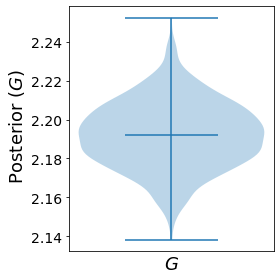

In [50]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
# plt.plot(1,params_true[0] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

The following code-block shows the plot of $G_{SBI}$ versus age.

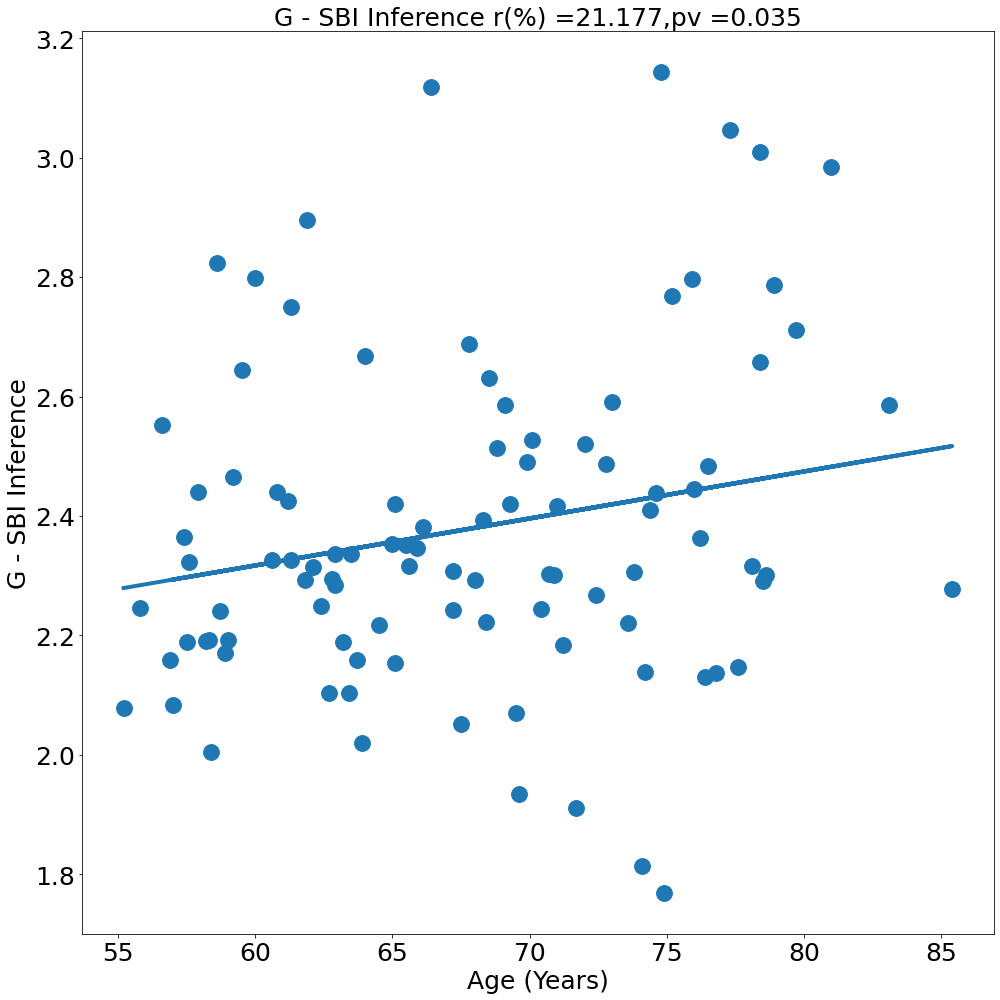

In [52]:
from scipy import stats
import pandas as pd
import seaborn as sns
path_root   = os.path.dirname(os.path.dirname(os.getcwd()))



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(14,14))

row_idx = 0
col_idx = 0


font_size = 25

feat_list = ['G - SBI Inference']
    
mymat    = np.mean(G_POST_MATRIX,axis=0)

cc_sc    = mymat
age_cc   = myage_list

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})


separator = ''
str_yaxis = separator.join(feat_list)

ax.scatter(age_cc, cc_sc,s=250)
ax.plot(age_cc, cc_hat,linewidth=4)
ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_xlabel("Age (Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size))

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

f.tight_layout()


The following code-block shows the comparison between $G_{SBI}$ versus $G_{sweep}$

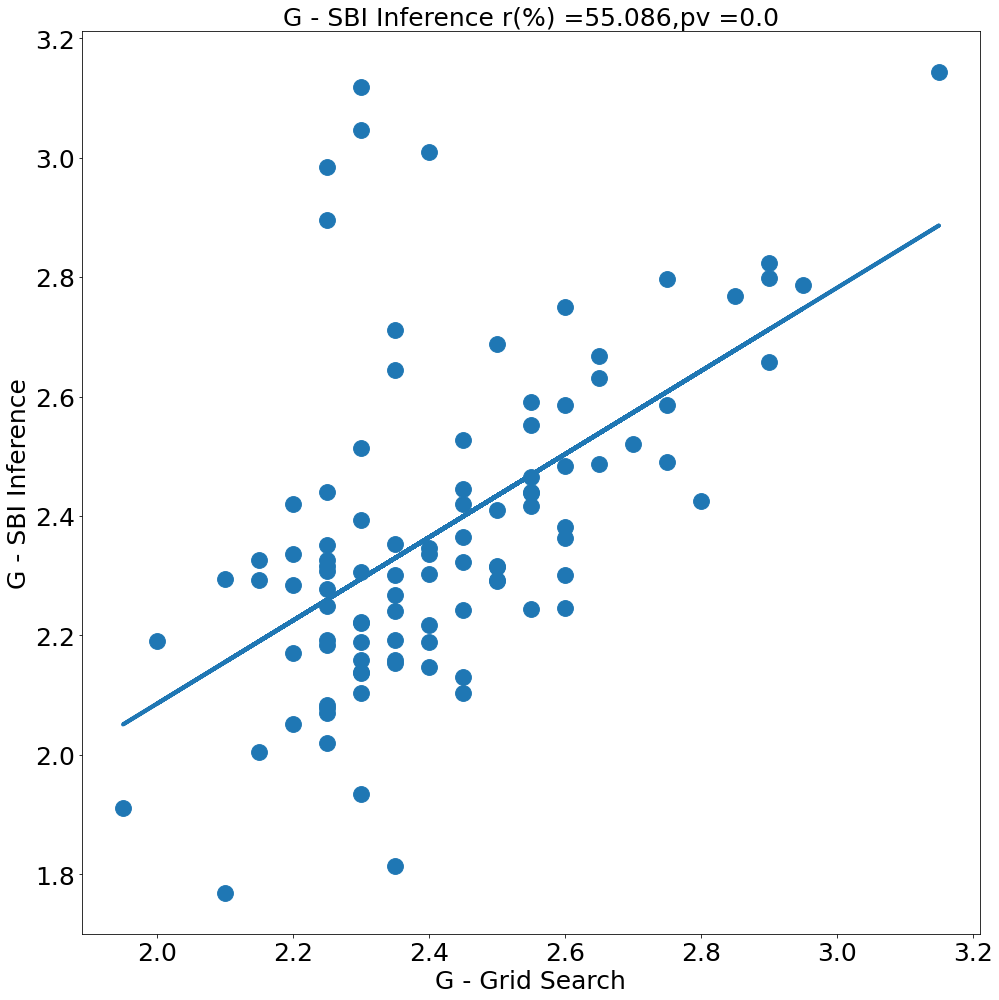

In [53]:
import seaborn as sns
path_root   = os.path.dirname(os.path.dirname(os.getcwd()))

cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(14,14))


font_size = 25

feat_list = ['G - SBI Inference']

    
mymat    = np.mean(G_POST_MATRIX,axis=0)

cc_sc    = mymat
age_cc   = G_MAX

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

separator = ''
str_yaxis = separator.join(feat_list)

ax.scatter(age_cc, cc_sc,s=250)
ax.plot(age_cc, cc_hat,linewidth=4)
#     sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax[row_idx,col_idx],ci=None)
ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_xlabel("G - Grid Search",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
# ax.set_xlim([55,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

row_idx = row_idx + 1

if row_idx > 1:
    row_idx = 0
    col_idx = 1
    
    
f.tight_layout()


The code block shows the posterior distributions for the selected subcohort

In [54]:
import pandas as pd
import seaborn as sns
age_rep        = np.repeat(np.array(myage_list),G_POST_MATRIX.shape[0])
subj_rep        = np.repeat(np.array(mysubj_list),G_POST_MATRIX.shape[0])
G_POST_RESHAPE = np.ravel(G_POST_MATRIX.T)
df_SC    = pd.DataFrame(
            {'age':age_rep ,'gcoup':G_POST_RESHAPE,'subj':subj_rep})

Text(0.5, 1.0, 'G - SBI Inference')

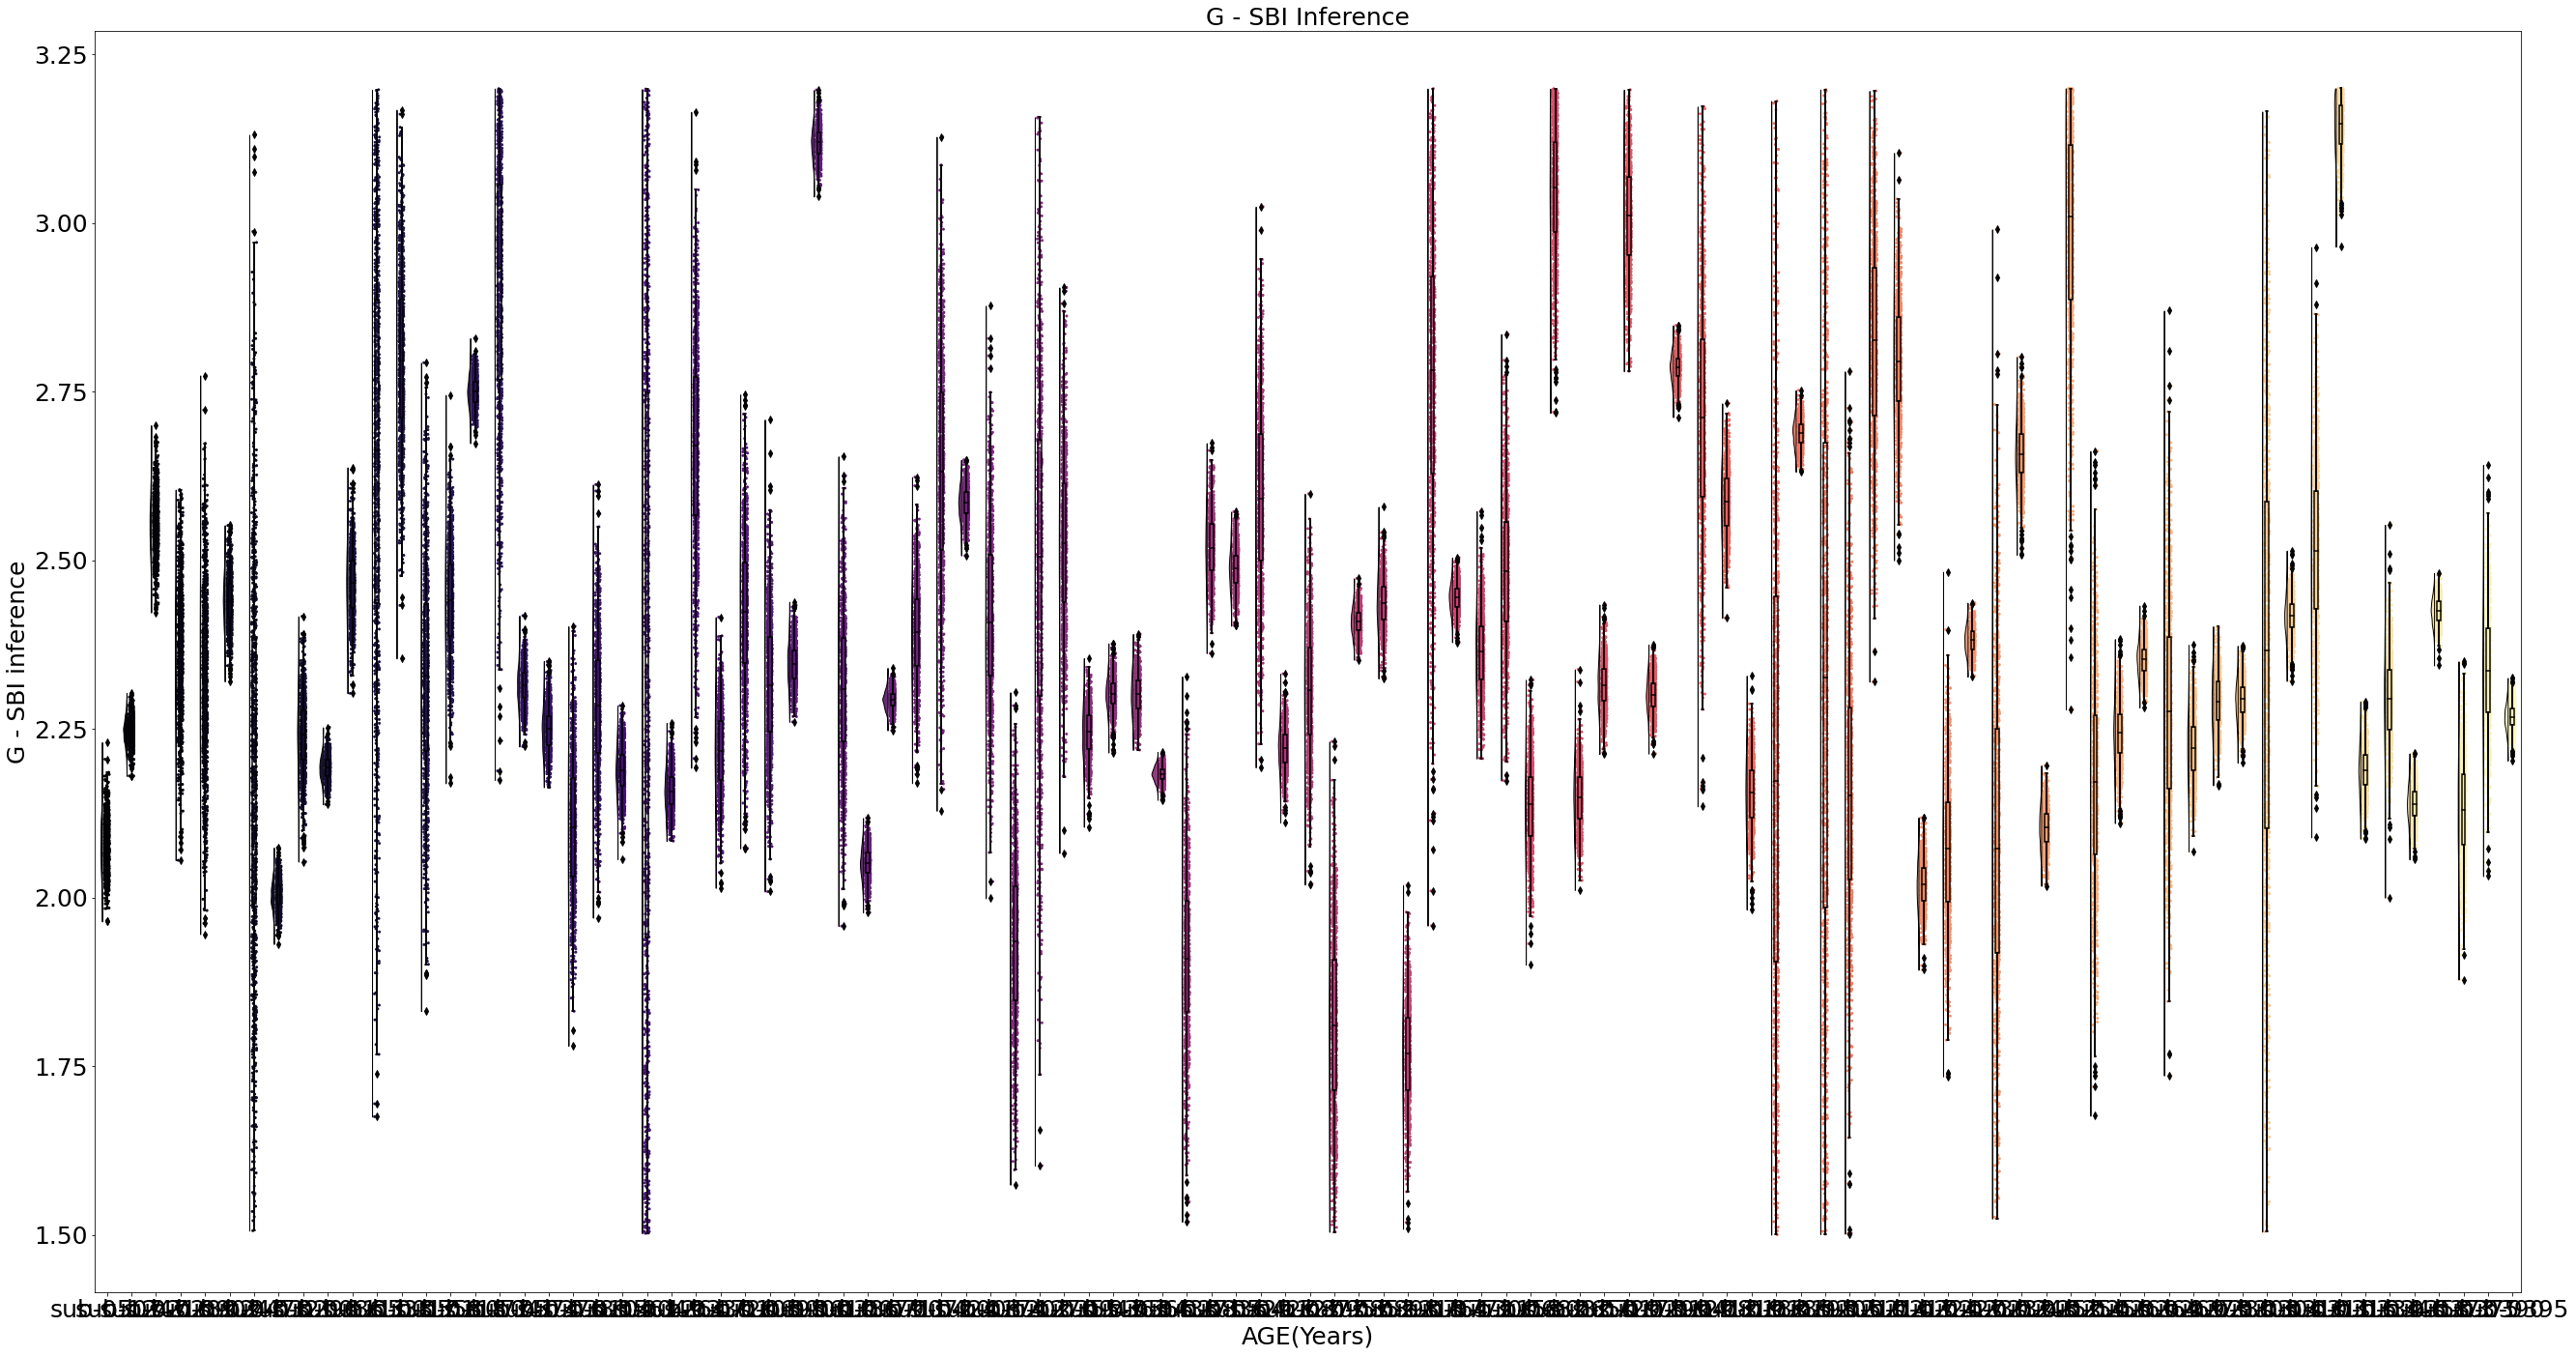

In [55]:
import ptitprince as pt
from scipy import stats
from statannot import add_stat_annotation
separator = ''
dx="subj"; dy="gcoup"; ort="v"; pal = "magma"; sigma = .2
f, ax = plt.subplots(figsize=(45, 24))
ax=pt.RainCloud(x = dx, y = dy, data = df_SC , palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort)

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

# sns.boxplot(age_rep,G_POST_RESHAPE)
ax.set_ylabel("G - SBI inference",fontsize=25)
ax.set_xlabel("AGE(Years)",fontsize=25)

ax.grid(False)
str_feature = "G - SBI Inference" #Limbic Mask FC stream std
str_title  = separator.join([str_feature]) #' p_val = ',str(round(p,7))
ax.set_title(str_title, fontsize=25)